## Exploratory Data Analysis

In [31]:
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
from operator import xor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from ml_metrics import rmsle
%matplotlib inline

le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

air = {
    "reserve": pd.read_csv("data/air/air_reserve.csv", parse_dates=["visit_datetime", "reserve_datetime"]),
    "store_info": pd.read_csv("data/air/air_store_info.csv"),
    "visit_data": pd.read_csv("data/air/air_visit_data.csv", parse_dates=["visit_date"])
}

hpg = {
    "reserve": pd.read_csv("data/hpg/hpg_reserve.csv", parse_dates=["visit_datetime", "reserve_datetime"]),
    "store_info": pd.read_csv("data/hpg/hpg_store_info.csv")
}

date_info = pd.read_csv("data/date_info.csv", parse_dates=["calendar_date"])
store_id_relation = pd.read_csv("data/store_id_relation.csv")

ModuleNotFoundError: No module named 'lightgbm'

### Feature Analysis

###### Looking for correlations in data:

In [17]:
air["visit_data"]["num_of_week"] = air["visit_data"]["visit_date"].dt.dayofweek

corr_table = air["visit_data"]
corr_table["visitors"] = corr_table["visitors"].map(np.log1p)
corr_table = pd.merge(corr_table, air["store_info"], on="air_store_id")
corr_table = pd.merge(corr_table, date_info,
                      left_on="visit_date", right_on="calendar_date")
corr_table["air_area_name"] = corr_table["air_area_name"].str.partition(" ")
corr_table["weekend_flg"] = corr_table["num_of_week"].map(lambda n: 1 if n in (1,2) else 0)
corr_table["not_workday_flg"] = corr_table["holiday_flg"].combine(corr_table["weekend_flg"], xor)
corr_table = corr_table.drop(columns=["day_of_week", "visit_date"])
print(corr_table.head())

           air_store_id  visitors  num_of_week air_genre_name air_area_name  \
0  air_ba937bf13d40fb24  0.895607            2     Dining bar      Tōkyō-to   
1  air_25e9888d30b386df  0.879129            2        Izakaya      Tōkyō-to   
2  air_fd6aac1043520e83  0.936268            2        Izakaya      Tōkyō-to   
3  air_64d4491ad8cdb1c6  0.706395            2     Dining bar      Tōkyō-to   
4  air_ee3a01f0c71a769f  0.863863            2    Cafe/Sweets  Shizuoka-ken   

    latitude   longitude calendar_date  holiday_flg  weekend_flg  \
0  35.658068  139.751599    2016-01-13            0            1   
1  35.626568  139.725858    2016-01-13            0            1   
2  35.658068  139.751599    2016-01-13            0            1   
3  35.658068  139.751599    2016-01-13            0            1   
4  34.710895  137.725940    2016-01-13            0            1   

   not_workday_flg  
0                1  
1                1  
2                1  
3                1  
4          

In [18]:
print(corr_table.corr())

                 visitors  num_of_week  latitude  longitude  holiday_flg  \
visitors         1.000000     0.140798 -0.004658  -0.003924     0.021715   
num_of_week      0.140798     1.000000  0.001297  -0.010168    -0.051138   
latitude        -0.004658     0.001297  1.000000   0.652447     0.002631   
longitude       -0.003924    -0.010168  0.652447   1.000000    -0.011698   
holiday_flg      0.021715    -0.051138  0.002631  -0.011698     1.000000   
weekend_flg     -0.071424    -0.501604  0.000661   0.012579    -0.090868   
not_workday_flg -0.062463    -0.490901  0.001385   0.008311     0.276030   

                 weekend_flg  not_workday_flg  
visitors           -0.071424        -0.062463  
num_of_week        -0.501604        -0.490901  
latitude            0.000661         0.001385  
longitude           0.012579         0.008311  
holiday_flg        -0.090868         0.276030  
weekend_flg         1.000000         0.885250  
not_workday_flg     0.885250         1.000000  


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EBE8886F28>,
      dtype=object)

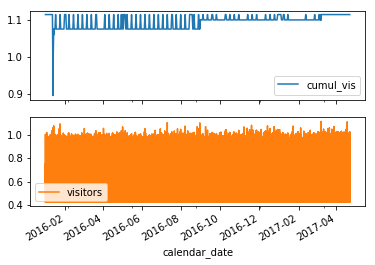

In [28]:
corr_table["cumul_vis"] = corr_table["visitors"].cummax()
corr_table.loc[:,["calendar_date", "cumul_vis", "visitors"]].plot.line(x="calendar_date", subplots=True)

### Applying ML